## Housing Price Predictions (Troy, MI)

The project demonstrates the process of housing price prediction using tree based methods. It includes data description, EDA procedure, analysis (model building and training), results, and conclusions. 

### 1. Scrape MLS Listings using HomeHarvest library

In [12]:
from homeharvest import scrape_property
from datetime import datetime

# Generate filename based on current timestamp
current_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"HomeHarvest_{current_timestamp}.csv"

properties = scrape_property(
  location="Novi, MI",
  listing_type="sold",  # or (for_sale, for_rent, pending)
#   past_days=30,  # sold in last 30 days - listed in last 30 days if (for_sale, for_rent)

  date_from="2023-09-25", # alternative to past_days
  date_to="2024-09-25",
  # foreclosure=True
  # mls_only=True,  # only fetch MLS listings
)
print(f"Number of properties: {len(properties)}")

# Export to csv
properties.to_csv(filename, index=False)
print(properties.head())

Number of properties: 568
                                        property_url property_id  listing_id  \
0  https://www.realtor.com/realestateandhomes-det...  4584257854  2971934248   
1  https://www.realtor.com/realestateandhomes-det...  4384936146  2969891327   
2  https://www.realtor.com/realestateandhomes-det...  4408637286  2971414206   
3  https://www.realtor.com/realestateandhomes-det...  4255497710  2970731297   
4  https://www.realtor.com/realestateandhomes-det...  4880592777  2970474636   

    mls       mls_id status  \
0  DEMI  20240067894   SOLD   
1  DEMI  20240053029   SOLD   
2  DEMI  20240063240   SOLD   
3  DEMI  20240058021   SOLD   
4  DEMI  20240057950   SOLD   

                                                text          style  \
0  Available again with new furnace, primary sump...  SINGLE_FAMILY   
1  Welcome to Country Place! This 1100 sq. ft con...         CONDOS   
2  Welcome to 22410 Mill Road in Whispering Meado...  SINGLE_FAMILY   
3  Welcome to this cha

### 2. Exploratory Data Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf


In [3]:
df = pd.read_csv('HomeHarvest_Troy_MI.csv')
print(df.shape)

(696, 57)


The dataset has 696 rows and 57 columns, which means the total number of homes sold between 9/25/23 to 9/25/24 in Troy, MI is 696. There are 57 features of each data point.

In [4]:
df.columns

Index(['property_url', 'property_id', 'listing_id', 'mls', 'mls_id', 'status',
       'text', 'style', 'full_street_line', 'street', 'unit', 'city', 'state',
       'zip_code', 'beds', 'full_baths', 'half_baths', 'sqft', 'year_built',
       'days_on_mls', 'list_price', 'list_price_min', 'list_price_max',
       'list_date', 'sold_price', 'last_sold_date', 'assessed_value',
       'estimated_value', 'new_construction', 'lot_sqft', 'price_per_sqft',
       'latitude', 'longitude', 'neighborhoods', 'county', 'fips_code',
       'stories', 'hoa_fee', 'parking_garage', 'agent_id', 'agent_name',
       'agent_email', 'agent_phones', 'agent_mls_set', 'agent_nrds_id',
       'broker_id', 'broker_name', 'builder_id', 'builder_name', 'office_id',
       'office_mls_set', 'office_name', 'office_email', 'office_phones',
       'nearby_schools', 'primary_photo', 'alt_photos'],
      dtype='object')

The dataset contains the detailed information including:

* The number of bedrooms and bathrooms
* The total living area
* The lot size
* Location
* Various amenities and features

In [5]:
# Drop unrelated columns
unrelated_cols = ['property_url', 'listing_id', 'mls', 'mls_id', 'status',
       'text', 'full_street_line', 'street', 'unit', 'zip_code','list_price_min', 'list_price_max', 
       'last_sold_date', 'assessed_value', 
       'neighborhoods', 'county', 'fips_code',
       'agent_id', 'agent_name', 'agent_email', 'agent_phones', 'agent_mls_set', 'agent_nrds_id',
       'broker_id', 'broker_name', 'builder_id', 'builder_name', 'office_id',
       'office_mls_set', 'office_name', 'office_email', 'office_phones',
       'nearby_schools', 'primary_photo', 'alt_photos']
df = df.drop(unrelated_cols, axis = 1)

In [6]:
# reduced dataframe info
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   property_id       696 non-null    int64  
 1   style             696 non-null    object 
 2   city              696 non-null    object 
 3   state             696 non-null    object 
 4   beds              690 non-null    float64
 5   full_baths        689 non-null    float64
 6   half_baths        483 non-null    float64
 7   sqft              689 non-null    float64
 8   year_built        690 non-null    float64
 9   days_on_mls       683 non-null    float64
 10  list_price        694 non-null    float64
 11  list_date         694 non-null    object 
 12  sold_price        696 non-null    int64  
 13  estimated_value   668 non-null    float64
 14  new_construction  696 non-null    bool   
 15  lot_sqft          565 non-null    float64
 16  price_per_sqft    689 non-null    float64
 1

The reduced dataframe has 22 features. 1 column has bool datatype, 15 columns have float64 data type, 2 columns has int64 datatype and 4 columns have object data type.

In [7]:
# drop the specific rows where at least one element in subset of cols is missing
df = df.dropna(subset = ['beds', 'full_baths', 'sqft', 'year_built', 'days_on_mls', 'list_price', 
                         'list_date', 'sold_price', 'estimated_value', 
                        'new_construction', 'lot_sqft', 'stories', 'hoa_fee',
                        'latitude', 'longitude'])


In [8]:
# Analyze data for single family house
df = df[df['style'] == 'SINGLE_FAMILY']

In [9]:
df.describe()

,property_id,beds,full_baths,half_baths,sqft,year_built,days_on_mls,list_price,sold_price,estimated_value,lot_sqft,price_per_sqft,latitude,longitude,stories,hoa_fee,parking_garage
count,5.350000e+02,535.000000,535.000000,378.000000,535.000000,535.000000,535.000000,5.350000e+02,5.350000e+02,5.350000e+02,535.000000,535.000000,535.000000,535.000000,535.000000,535.000000,493.000000
mean,4.252979e+09,3.588785,2.127103,1.140212,2202.297196,1976.097196,44.317757,5.051251e+05,5.134583e+05,5.181527e+05,16122.876636,232.740187,42.584096,-83.142227,1.641121,5.801869,2.119675
std,1.225186e+09,0.661307,0.822617,0.355214,803.665903,18.339748,29.262597,2.504365e+05,2.477497e+05,2.461238e+05,13419.647772,44.046470,0.022105,0.036653,0.502979,14.592402,0.505939
min,3.000179e+09,1.000000,1.000000,1.000000,617.000000,1920.000000,0.000000,1.300000e+05,1.150000e+05,1.449000e+05,6098.000000,100.000000,42.534587,-83.206603,1.000000,0.000000,1.000000
25%,3.565629e+09,3.000000,2.000000,1.000000,1630.000000,1967.000000,28.000000,3.570000e+05,3.700000e+05,3.727585e+05,9583.000000,203.000000,42.569081,-83.176217,1.000000,0.000000,2.000000
50%,4.106229e+09,4.000000,2.000000,1.000000,2105.000000,1975.000000,37.000000,4.500000e+05,4.630000e+05,4.673500e+05,13068.000000,230.000000,42.584151,-83.135570,2.000000,0.000000,2.000000
75%,4.584372e+09,4.000000,3.000000,1.000000,2657.000000,1988.000000,53.000000,6.191940e+05,6.252500e+05,6.348500e+05,18077.500000,256.000000,42.601064,-83.107833,2.000000,6.000000,2.000000
max,9.944871e+09,6.000000,6.000000,3.000000,7514.000000,2024.000000,226.000000,3.500000e+06,3.500000e+06,3.484600e+06,162043.000000,466.000000,42.622535,-83.088803,4.000000,158.000000,6.000000


* The average single family house sold price is about 513,458 dollars, with a standard deviation of 247,750 dollars
* The average price per square ft is 233 dollars, with a standard deviation of 44 dollars
* The average days from home being listed to it being sold is 44 days.
* The average area is 2202 square ft, with a minimum of 617 sqft and maximum of 7514 sqft
* The average lot size is 16123 sqft, with a minimum of 6098 sqft and maximum of 162,043 sqft
* The average year of built is 1976, with a oldest of 1920 and newest of 2024.
* Most houses have 3-4 bedrooms, with an average of 3.6
* The majority of houses have 2-3 full bathrooms, with an average of 2.1
* Houses typically have 1-2 stories, with an average of 1.6
* Parking spaces range from 0 to 6, with an average of 2.1

In [10]:
unique_counts = df.nunique()
print("Number of unique values per column:")
print(unique_counts)

Number of unique values per column:
property_id         535
style                 1
city                  1
state                 1
beds                  6
full_baths            6
half_baths            3
sqft                441
year_built           85
days_on_mls          99
list_price          294
list_date           257
sold_price          307
estimated_value     518
new_construction      2
lot_sqft             79
price_per_sqft      172
latitude            530
longitude           534
stories               4
hoa_fee              36
parking_garage        5
dtype: int64


In [11]:
# Check for missing values in the dataset
missing_values = df.isnull().sum()

# Display the count of missing values for each column
print("Missing values in each column:")
print(missing_values)

# Verify if the dataset is clean (no missing values)
if missing_values.sum() == 0:
    print("\nThe dataset is clean: No missing values found.")
else:
    print(f"\nThe dataset contains {missing_values.sum()} missing values.")

Missing values in each column:
property_id           0
style                 0
city                  0
state                 0
beds                  0
full_baths            0
half_baths          157
sqft                  0
year_built            0
days_on_mls           0
list_price            0
list_date             0
sold_price            0
estimated_value       0
new_construction      0
lot_sqft              0
price_per_sqft        0
latitude              0
longitude             0
stories               0
hoa_fee               0
parking_garage       42
dtype: int64

The dataset contains 199 missing values.


There are 157 homes with no half bathroom and 42 homes with no parking garage.

In [12]:
# replace nan in half_baths and parking_garage with zero
df.fillna(0, inplace=True)

In [13]:
# extract listing month from the string and create new feature 'sales_month'
df['sales_month'] = df.list_date.apply(lambda x: int(x[: x.find('/')]))

In [14]:
# Find the month with most and least number of sales
by_month_count = df.groupby('sales_month')['property_id'].count()
print(by_month_count)
most_sales_month = by_month_count.idxmax()
least_sales_month = by_month_count.idxmin()
print('Month with most number of home sales: ', most_sales_month)
print('Month with least number of home sales: ', least_sales_month)

sales_month
1     38
2     28
3     45
4     53
5     63
6     65
7     69
8     48
9     37
10    35
11    28
12    26
Name: property_id, dtype: int64
Month with most number of home sales:  7
Month with least number of home sales:  12


Text(0, 0.5, 'Median Housing Price')

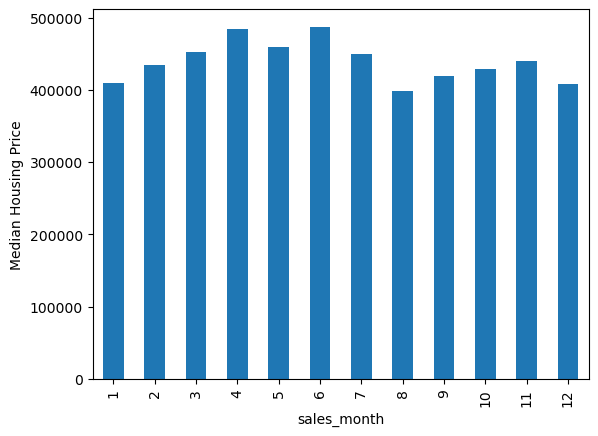

In [15]:
# explore seasonality on housing price
df_s = df[df['sold_price'] < 800000]
seasonality = df_s.groupby('sales_month')['sold_price'].median()
seasonality.plot.bar()
plt.ylabel('Median Housing Price')

For the house price lower than $800,000, the housing price goes up from January to June and reaches the peak in June. It goes down from June to August and start raising toward November and settle down at the end of the year.

### Outlier detection and treatment

In [16]:
numeric_cols = ['beds', 'full_baths', 'half_baths', 'sqft', 
                'year_built', 'days_on_mls', 'list_price', 'sold_price',
               'estimated_value', 'lot_sqft', 'price_per_sqft',
                'stories', 'hoa_fee', 'parking_garage', 'latitude', 'longitude']

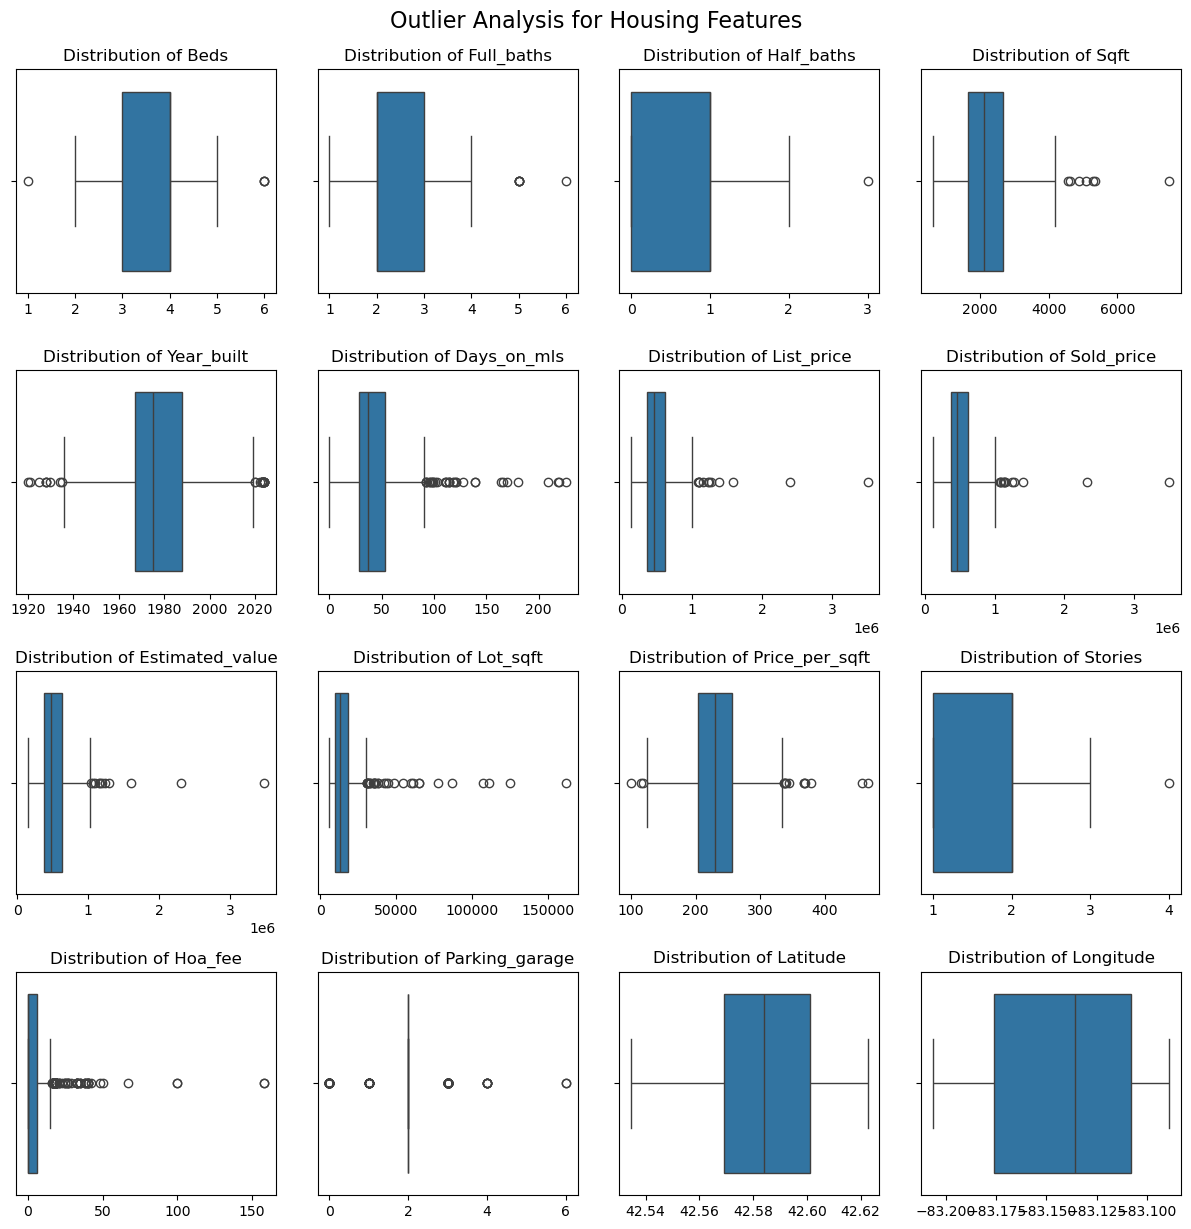

In [17]:
plt.figure(figsize=(12, 12))
for i, col in enumerate(numeric_cols):
    plt.subplot(4, 4, i+1)
    sns.boxplot(x=df[col])
    plt.title(f'Distribution of {col.capitalize()}', fontsize=12)
    plt.xlabel('')
    
plt.tight_layout()
plt.suptitle('Outlier Analysis for Housing Features', fontsize=16, y=1.02)
plt.show()  

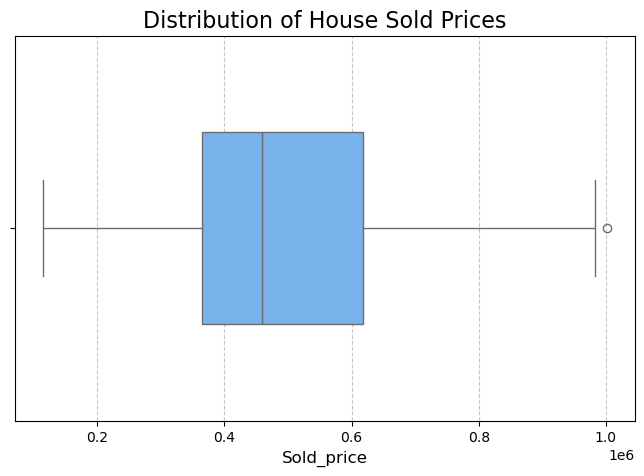

In [18]:
# Sold price and area have many outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

def plot_boxplot(df, column, color, title):
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df[column], color=color, width=0.5)
    plt.title(title, fontsize=16)
    plt.xlabel(column.capitalize(), fontsize=12)
    plt.ylabel('', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()
    
df = remove_outliers(df, 'sold_price')
plot_boxplot(df, 'sold_price', '#66b3ff', 'Distribution of House Sold Prices')


In [19]:
df.columns

Index(['property_id', 'style', 'city', 'state', 'beds', 'full_baths',
       'half_baths', 'sqft', 'year_built', 'days_on_mls', 'list_price',
       'list_date', 'sold_price', 'estimated_value', 'new_construction',
       'lot_sqft', 'price_per_sqft', 'latitude', 'longitude', 'stories',
       'hoa_fee', 'parking_garage', 'sales_month'],
      dtype='object')

In [20]:
df.shape

(523, 23)

In [21]:
df.describe()

,property_id,beds,full_baths,half_baths,sqft,year_built,days_on_mls,list_price,sold_price,estimated_value,lot_sqft,price_per_sqft,latitude,longitude,stories,hoa_fee,parking_garage,sales_month
count,5.230000e+02,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,5.230000e+02,5.230000e+02,5.230000e+02,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000,523.000000
mean,4.267588e+09,3.565966,2.082218,0.793499,2149.208413,1975.332696,44.061185,4.822448e+05,4.916696e+05,4.963330e+05,15584.126195,230.780115,42.583846,-83.141127,1.634799,4.782027,1.929254,6.235182
std,1.233752e+09,0.643973,0.767472,0.589983,709.926622,17.744143,28.798482,1.718232e+05,1.744133e+05,1.716001e+05,11215.343803,40.941172,0.022208,0.036224,0.505234,9.470781,0.738102,3.013403
min,3.000179e+09,1.000000,1.000000,0.000000,617.000000,1920.000000,0.000000,1.300000e+05,1.150000e+05,1.449000e+05,6098.000000,100.000000,42.534587,-83.206401,1.000000,0.000000,0.000000,1.000000
25%,3.575432e+09,3.000000,2.000000,0.000000,1612.000000,1967.000000,28.000000,3.500000e+05,3.655000e+05,3.706000e+05,9583.000000,203.000000,42.568651,-83.174234,1.000000,0.000000,2.000000,4.000000
50%,4.118888e+09,4.000000,2.000000,1.000000,2082.000000,1974.000000,37.000000,4.499000e+05,4.600000e+05,4.639000e+05,13068.000000,229.000000,42.583863,-83.134608,2.000000,0.000000,2.000000,6.000000
75%,4.589980e+09,4.000000,3.000000,1.000000,2613.000000,1987.000000,53.000000,5.999000e+05,6.180000e+05,6.235065e+05,17860.000000,254.000000,42.600963,-83.107422,2.000000,4.500000,2.000000,8.000000
max,9.944871e+09,6.000000,5.000000,2.000000,4606.000000,2024.000000,226.000000,1.090000e+06,1.001111e+06,1.032800e+06,125017.000000,369.000000,42.622535,-83.088803,4.000000,67.000000,6.000000,12.000000


In [22]:
# drop unnecessary features for modeling
df = df.drop(['property_id', 'style', 'city', 'state', 'days_on_mls', 
              'list_price', 'list_date', 'estimated_value', 'price_per_sqft'], axis = 1)

In [23]:
# Place the sold_price at first column
col = df.pop('sold_price')
df.insert(0, 'sold_price', col)

In [24]:
# correlation matrix
df.corr()

,sold_price,beds,full_baths,half_baths,sqft,year_built,new_construction,lot_sqft,latitude,longitude,stories,hoa_fee,parking_garage,sales_month
sold_price,1.000000,0.557516,0.640940,0.453356,0.868644,0.647806,0.197646,0.110711,0.285342,-0.460984,0.490850,0.524304,0.334080,-0.088280
beds,0.557516,1.000000,0.487089,0.298118,0.649402,0.384009,0.098886,0.033070,0.175374,-0.213591,0.571723,0.266525,0.160976,-0.007516
full_baths,0.640940,0.487089,1.000000,0.046030,0.629498,0.404815,0.105935,0.082079,0.226296,-0.265607,0.349314,0.276837,0.247015,-0.015004
half_baths,0.453356,0.298118,0.046030,1.000000,0.448700,0.376587,-0.016469,-0.075941,0.195283,-0.206249,0.318503,0.207924,0.155553,-0.010345
sqft,0.868644,0.649402,0.629498,0.448700,1.000000,0.574610,0.131677,0.094075,0.355074,-0.379067,0.565355,0.473480,0.223074,-0.023276
year_built,0.647806,0.384009,0.404815,0.376587,0.574610,1.000000,0.397891,-0.165625,0.140137,0.010651,0.353985,0.436979,0.254411,0.020174
new_construction,0.197646,0.098886,0.105935,-0.016469,0.131677,0.397891,1.000000,-0.051045,-0.172856,0.016428,0.106051,0.207582,-0.040149,-0.073417
lot_sqft,0.110711,0.033070,0.082079,-0.075941,0.094075,-0.165625,-0.051045,1.000000,0.234740,-0.310602,0.007699,-0.018261,0.150072,-0.062629
latitude,0.285342,0.175374,0.226296,0.195283,0.355074,0.140137,-0.172856,0.234740,1.000000,-0.189273,0.213812,0.173145,0.210091,-0.068748
longitude,-0.460984,-0.213591,-0.265607,-0.206249,-0.379067,0.010651,0.016428,-0.310602,-0.189273,1.000000,-0.168335,-0.189748,-0.197166,0.084436


<Axes: >

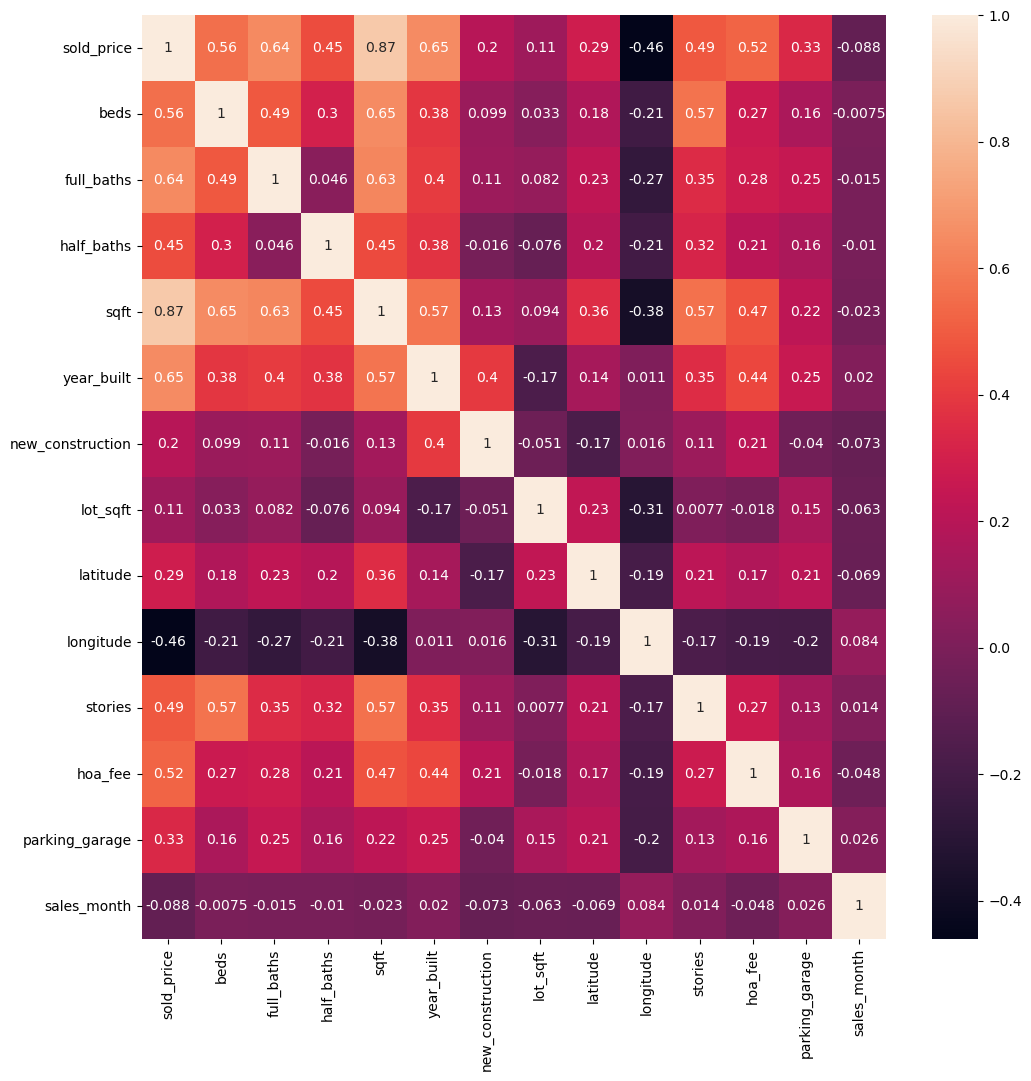

In [25]:
# visualizing correlation matrix using a heatmap
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(df.corr(), annot = True)

In [26]:
# #inspecting relationships between features using a pair plot. 
# sns.pairplot(df.iloc[:,1:])

In [27]:
# Check for duplicate rows in the dataset
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 0


In [28]:
# check what unique values exist in each column.
for c in df.columns[2:]:
    print(c, df[c].unique())

full_baths [3. 1. 2. 4. 5.]
half_baths [0. 1. 2.]
sqft [3200. 1441. 2400. 2200. 1546. 1995. 1988. 2114. 2199. 2623. 2665. 2518.
 2082. 2860. 1050. 1975. 1036. 2786. 3799. 1326. 3037. 1955. 2904. 1722.
 1709. 2962. 2050. 3129. 2425. 3164. 1796. 1436. 2041. 1582. 1560. 2093.
 4606. 1426. 2000. 2956. 1768. 2214. 2440. 3007. 1507. 2532.  936. 1891.
 1717. 1197. 2116. 2794. 1754. 4550. 1777. 3900. 2070. 1035. 2700. 1859.
 3181. 3300. 1875. 1671. 3444. 1073. 1901. 1265. 2008. 3077. 2929. 1533.
 1876. 1682. 1501. 2161. 1834. 2493. 3254. 2354. 3683. 2413. 2445. 2073.
 2937. 2600. 1283.  825. 2800. 2640. 2303. 1248. 1911. 3097. 1498. 2895.
 1245. 1700. 1970. 3749. 2454. 2407. 1559. 2598. 2487. 3312. 3895. 3266.
 2250. 1854. 2835. 2020. 2095. 2752. 2654. 2325. 2681. 2554. 2430. 2128.
 2765. 3521. 2500. 1445. 1703. 1444. 2329. 1500. 2231. 3116. 2622. 1434.
 1782. 2142. 2808. 2497. 2419. 3956. 1512. 2007. 3311. 2843. 1626. 2015.
 2482. 2415. 1322. 1460. 1286. 2277. 1648. 2044. 1292. 2488. 1557. 22

There are no nan (s) in all columns.

In [29]:
# replace nan with zero
print(df['half_baths'].unique())
print(df['parking_garage'].unique())

[0. 1. 2.]
[2. 0. 3. 1. 4. 6.]


## 3. Model Building and Training

The dataset is relatively small the number of features is relatively large. Random forest utilizing bagging and decorrelation of features is a proper method to start with.

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [31]:
# Assign x and y variables
x = df.iloc[:, 1:]
y = df['sold_price']

In [32]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 7)

### Random Forest

In [33]:
rf_scores = dict()
n_tree_rg = np.arange(50, 600, 50)
for n_features in [None, 'sqrt']:
    sub_scores = []
    for n_trees in n_tree_rg:
        rf_model = RandomForestRegressor(n_estimators = n_trees, max_features = n_features, random_state = 7)
        rf_model.fit(x_train, y_train)
        score = rf_model.score(x_test, y_test)
        sub_scores.append(score)
    rf_scores[n_features] = sub_scores

In [34]:
print(rf_scores)

{None: [0.8091822166166003, 0.8145136349609159, 0.8136240480262289, 0.812098573026114, 0.8111636070431351, 0.8121367369435274, 0.8126352476088607, 0.8116949908166387, 0.8117629200942398, 0.811559973620082, 0.811845721516081], 'sqrt': [0.8067555825441933, 0.8089024167752265, 0.8079967908534147, 0.8101140480858583, 0.8113726335174631, 0.8126140917533544, 0.8133452493341307, 0.8119743587810597, 0.8126895609864498, 0.8120978556487267, 0.8115642088312489]}


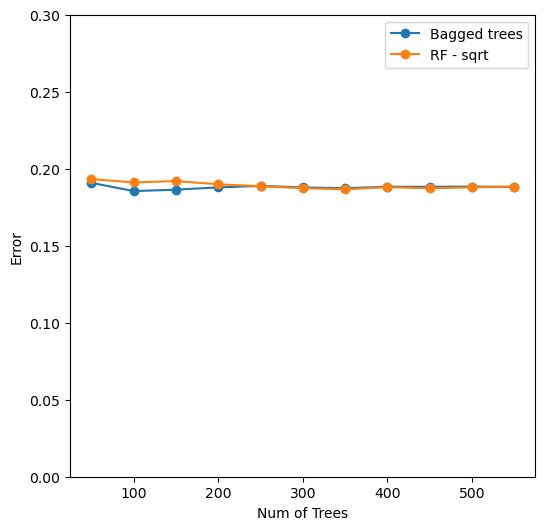

In [35]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(n_tree_rg, 1 - np.array(rf_scores[None]), marker='o', label = 'Bagged trees')
ax.plot(n_tree_rg, 1 - np.array(rf_scores['sqrt']), marker='o', label = 'RF - sqrt')
ax.set_ylim([0, 0.30])
ax.set_ylabel('Error')
ax.set_xlabel('Num of Trees')
ax.legend()
plt.show()

Bagging is better than Random Forest with max_features as sqrt(num of features) for Troy dataset

### Gradient Boosting

In [36]:
gb_scores = dict()
n_tree_rg = np.arange(50, 600, 50)
for n_features in [None, 'sqrt']:
    sub_scores = []
    for n_trees in n_tree_rg:
        gb_model = GradientBoostingRegressor(n_estimators = n_trees, max_features = n_features, max_depth = 1, random_state = 7)
        gb_model.fit(x_train, y_train)
        score = gb_model.score(x_test, y_test)
        sub_scores.append(score)
    gb_scores[n_features] = sub_scores

In [37]:
print(gb_scores)

{None: [0.7716286288871439, 0.82395924021468, 0.8395691256144777, 0.8434626206221162, 0.8471178799619882, 0.8491945518448324, 0.8507033830133054, 0.8508902439337024, 0.8497284003954793, 0.8489539452549582, 0.8482707104207032], 'sqrt': [0.7295314761017366, 0.7892292048032796, 0.802381210004437, 0.810219572175081, 0.8152342839223036, 0.818163378727262, 0.8204361218708578, 0.822524586770983, 0.8234737685499213, 0.8252071423015851, 0.8254537142274193]}


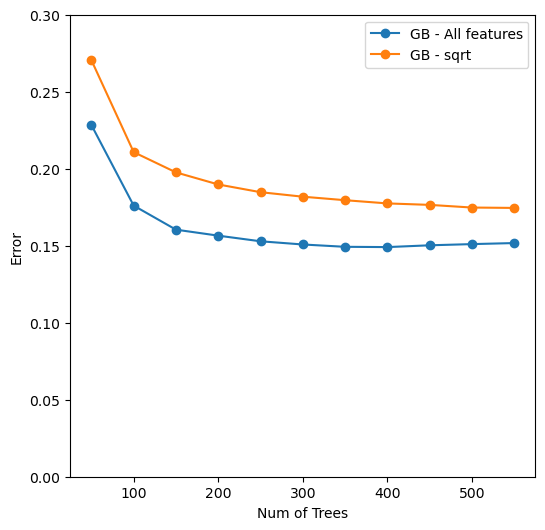

In [38]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(n_tree_rg, 1 - np.array(gb_scores[None]), marker='o', label = 'GB - All features')
ax.plot(n_tree_rg, 1 - np.array(gb_scores['sqrt']), marker='o', label = 'GB - sqrt')
ax.set_ylim([0, 0.30])
ax.set_ylabel('Error')
ax.set_xlabel('Num of Trees')
ax.legend()
plt.show()

Considering all features when looking for best split performs better than sqrt(n_features)

## 4. Results

Looking at above two graph, Gradient Boosting considering all features has the highest accuracy.

In [39]:
m = None
rf_res = max(rf_scores[m])
n_trees_best_rf = n_tree_rg[rf_scores[m].index(rf_res)]
print('Best num of trees for the random forest model:',n_trees_best_rf)

Best num of trees for the random forest model: 100


In [40]:
ab_res = max(gb_scores[m])
n_trees_best_gb = n_tree_rg[gb_scores[m].index(ab_res)]
print('Best num of boosting stage for the gradient boosting model:',n_trees_best_gb)

Best num of boosting stage for the gradient boosting model: 400


In [41]:
best_model_rf = RandomForestRegressor(n_estimators = n_trees_best_rf, max_features = m, random_state = 7).fit(x_train, y_train)

In [42]:
best_model_gb = GradientBoostingRegressor(n_estimators = n_trees_best_gb, max_features = m,
                                       max_depth = 1, random_state = 7).fit(x_train, y_train)

In [43]:
best_model_gb.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 1,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 400,
 'n_iter_no_change': None,
 'random_state': 7,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [45]:
best_acc_rf = best_model_rf.score(x_test, y_test)
best_acc_gb = best_model_gb.score(x_test, y_test)
print("Best accuracy is {:.3f}".format(best_acc_rf), 'using random forest.')
print("Best accuracy is {:.3f}".format(best_acc_gb), 'using gradient boosting.')

Best accuracy is 0.815 using random forest.
Best accuracy is 0.851 using gradient boosting.


## 5. Conclusion

In this project, I applied two tree based methods to build predictive models for sold price of single family house. The dataset is the real data scraped from realtor.com. and is about a specific city in Metro Detroit. 


In the first model, I utilized random forest regression including either all features (n_features) or sqrt(n_features) when considering best split. The results show that the model including all features, the bagged tree model, yield better results with building 100 trees in the forest. The accuracy is  81%. Then, I constructed a second model using gradient boosting regressor setting max depth of subtree as 1. Similarly, the model considering all features for the best split outputs better accuracy. The boosting model outperforms the random forest model and the highest accuracy is 85% with 400 boosting stages.


Overall, the model produces good accuracy. There are several strategies I plan to explore to further improve the predictive accuracy of my models. Firstly, I plan to separate finished basement area and living area above ground in the model as they would impact the sold price of the house differently. Moreover, I am also curious to see how support vector regression performs on the prediction comparing with tree based methods.

In summary, while my initial models offer valuable insights into property price prediction, there is ample potential for further enhancement. I am eager to continue exploring and experimenting to create more precise and reliable predictive models.